## @author - Pardeep
## transfer learning model using MobileNetV2
### reference :- https://keras.io/api/applications/mobilenet/#mobilenetv2-function

# Data Preprocessing

In [1]:
# using dplifolders splitting the data into train and test
import splitfolders

In [2]:
input_dataset="Segmented Medicinal Leaf Images"
output_dataset="splitted data"
splitfolders.ratio(input_dataset,output_dataset,seed=42,ratio=(.7,.2,.1)) # will split in train(70%), test(20%) and validation(10%)

Copying files: 1835 files [00:02, 747.57 files/s]


In [3]:
from keras.preprocessing.image import ImageDataGenerator

### Preprocessing the Training set

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('splitted data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1273 images belonging to 30 classes.


### Preprocessing the Test set

In [5]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('splitted data/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 206 images belonging to 30 classes.


### Preprocessing the val set

In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)
val_set = test_datagen.flow_from_directory('splitted data/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 356 images belonging to 30 classes.


# importing transfer learning model

In [7]:
# import necessary library
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential
from keras.layers import *

In [8]:
# load and creare a model object
v2model = MobileNetV2(input_shape=[224,224,3], weights='imagenet', include_top=False)
# model summary
v2model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# preprocessing pre trained model

In [9]:
for layer in v2model.layers:
    layer.trainable = False

## adding layer for flattening the outputs from previous layers

In [10]:
x = Flatten()(v2model.output)

## adding layer for classification

In [11]:
from glob import glob

In [12]:
# getting number of output classes
folders = glob('./splitted data/train/*')

In [13]:
prediction = Dense(len(folders), activation='softmax')(x)

In [14]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model

In [15]:
# create a model object
model = Model(inputs=v2model.input, outputs=prediction)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Training the transfer learning model

### Compiling the CNN

In [17]:
model.compile(optimizer = 'adam', loss = 'CategoricalCrossentropy', metrics = ['accuracy'])

### To avoid model to overfitting 

In [18]:
from keras.callbacks import EarlyStopping

In [19]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=3,verbose=2)

### Training the CNN on the Training set and evaluating it on the Test set

In [20]:
a= model.fit(training_set, validation_data = val_set,callbacks= earlystop,epochs = 20)

Epoch 1/20
40/40 [==============================] - 64s 2s/step - loss: 9.0856 - accuracy: 0.4939 - val_loss: 0.8745 - val_accuracy: 0.9157
Epoch 2/20
40/40 [==============================] - 54s 1s/step - loss: 1.0819 - accuracy: 0.9138 - val_loss: 0.6320 - val_accuracy: 0.9298
Epoch 3/20
40/40 [==============================] - 57s 1s/step - loss: 0.5206 - accuracy: 0.9585 - val_loss: 0.8575 - val_accuracy: 0.9410
Epoch 4/20
40/40 [==============================] - 55s 1s/step - loss: 0.2831 - accuracy: 0.9578 - val_loss: 0.6201 - val_accuracy: 0.9298
Epoch 5/20
40/40 [==============================] - 55s 1s/step - loss: 0.4293 - accuracy: 0.9535 - val_loss: 0.4538 - val_accuracy: 0.9663
Epoch 6/20
40/40 [==============================] - 56s 1s/step - loss: 0.2814 - accuracy: 0.9713 - val_loss: 0.6561 - val_accuracy: 0.9466
Epoch 7/20
40/40 [==============================] - 56s 1s/step - loss: 0.1533 - accuracy: 0.9827 - val_loss: 0.5212 - val_accuracy: 0.9579
Epoch 8/20
40/40 [==

## Making a single prediction

### accuracy and losses

In [21]:
test_loss, test_acc =model.evaluate(test_set,verbose = 2)
print("Test accuracy: ",test_acc)

7/7 - 7s - loss: 2.1419 - accuracy: 0.9078
Test accuracy:  0.9077669978141785


In [22]:
print("Test loss: ",test_loss)

Test loss:  2.141887903213501


In [23]:
import matplotlib.pyplot as plt

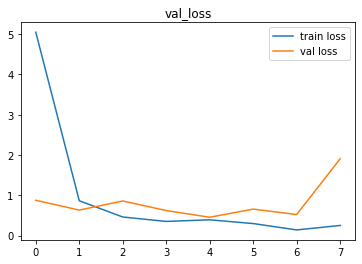

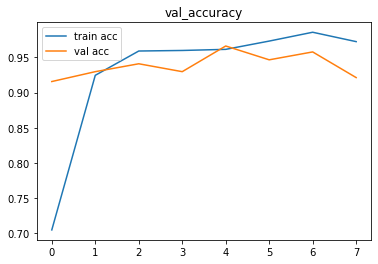

In [24]:
# plot the loss
plt.plot(a.history['loss'], label='train loss')
plt.plot(a.history['val_loss'], label='val loss')
plt.title('val_loss') 
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(a.history['accuracy'], label='train acc')
plt.plot(a.history['val_accuracy'], label='val acc')
plt.title('val_accuracy') 
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

## saving a model

In [26]:
import tensorflow as tf

# tflite format for Android interface

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('datasetmodelmobilenet.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\parde\AppData\Local\Temp\tmpzb83wpfd\assets
